# 1. Importación de librerías

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import joblib

# 2. Cargar datos

In [8]:
df = pd.read_csv("datos_tratados.csv")
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,19.776667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,18.080000
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,9.361667
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,41.261667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,8.913333


# 3. Normalización de columnas anidadas

In [9]:
# Eliminar la columna 'customerID'
df_final = df.drop(columns=['customerID'])

df_final.replace(['',' '], np.nan, inplace=True)
df_final.dropna(inplace=True)
df_final.sample(5)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
2046,0,Male,0,1,1,69,1,No,DSL,Yes,...,Yes,Yes,Yes,No,Two year,1,Bank transfer (automatic),75.75,5388.15,179.605000
887,1,Male,0,0,0,2,1,Yes,DSL,No,...,No,No,No,No,Month-to-month,1,Mailed check,54.40,114.10,3.803333
3022,0,Female,0,1,1,59,1,Yes,Fiber optic,No,...,No,Yes,No,Yes,Month-to-month,1,Bank transfer (automatic),96.65,5580.80,186.026667
6884,0,Male,0,1,1,45,1,Yes,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,1,Bank transfer (automatic),95.95,4456.65,148.555000
5662,0,Female,1,0,0,57,0,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,55.00,3094.05,103.135000


# 4. Preprocesamiento

# Encoding de variables categóricas

In [10]:
cat_cols = df_final.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df_final[col] = le.fit_transform(df_final[col])

# Manejo de multicolinealidad

In [11]:
corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_final.drop(columns=to_drop, inplace=True)

#Verificación de proporción de Churn

Número de clientes por clase:
Churn
0    5387
1    1869
Name: count, dtype: int64

Proporción de clientes por clase:
Churn
0    0.74242
1    0.25758
Name: proportion, dtype: float64


/tmp/ipython-input-2292620445.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')


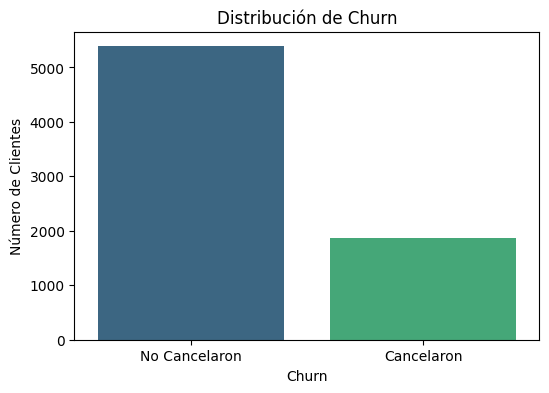

In [12]:
churn_counts = df_final['Churn'].value_counts()
churn_props = df_final['Churn'].value_counts(normalize=True)

print("Número de clientes por clase:")
print(churn_counts)
print("\nProporción de clientes por clase:")
print(churn_props)

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
plt.xticks([0,1], ['No Cancelaron', 'Cancelaron'])
plt.ylabel('Número de Clientes')
plt.title('Distribución de Churn')
plt.show()

# 5. Análisis Exploratorio

# Distribución de variables numéricas

In [13]:
for col in df_final.select_dtypes(include='number').columns:
    fig = px.histogram(df_final, x=col, color='Churn', title=f'Distribución de {col}')
    fig.show()

# Matriz de correlación

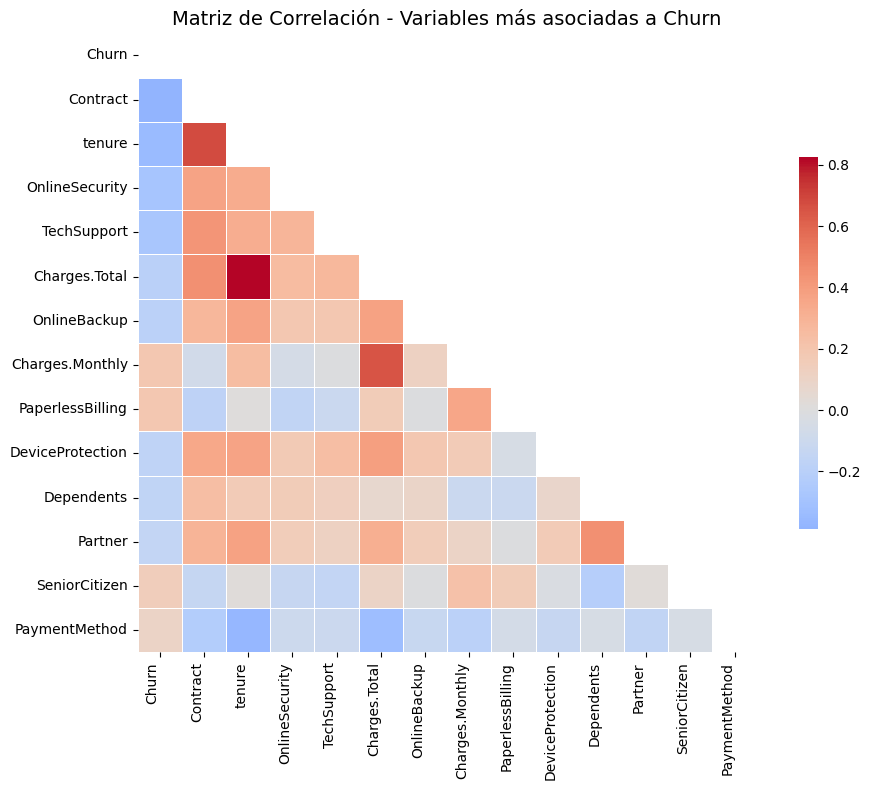

In [14]:
# Seleccionar variables más correlacionadas con Churn
cor_target = abs(df_final.corr()['Churn'])
variables_correlacionadas = cor_target[cor_target > 0.1].sort_values(ascending=False)  # Ajusta el umbral según convenga

vars_corr = list(variables_correlacionadas.index)  # Incluye Churn automáticamente

# Crear submatriz
sub_matriz = df_final[vars_corr].corr()

# Crear máscara para triángulo superior
mask = np.triu(np.ones_like(sub_matriz, dtype=bool))

# Tamaño y estilo del gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(sub_matriz,
            mask=mask,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .6},
            annot=False)  # Oculta los números
plt.title('Matriz de Correlación - Variables más asociadas a Churn', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


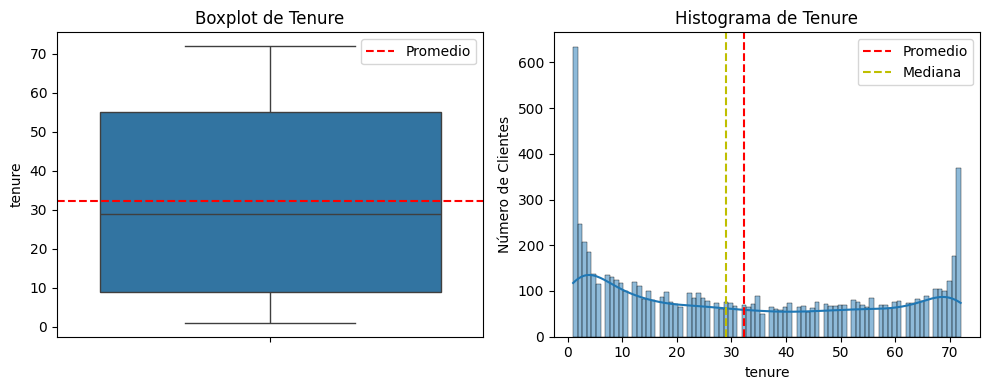

In [15]:
# Función para calcular ancho de bin
def ancho_bin(df, columna):
    rango = df[columna].max() - df[columna].min()
    n = int(np.sqrt(len(df[columna])))
    return rango / n

# Cálculo promedio y mediana
tenure_promedio = df_final['tenure'].mean()
tenure_mediana = df_final['tenure'].median()

# Crear figura con Boxplot e Histograma
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Boxplot
sns.boxplot(data=df_final, y='tenure', ax=ax[0])
ax[0].set_title('Boxplot de Tenure')
ax[0].axhline(y=tenure_promedio, color='r', linestyle='--', label='Promedio')
ax[0].legend()

# Histograma con KDE
binwidth = ancho_bin(df_final, 'tenure')
sns.histplot(data=df_final, x='tenure', ax=ax[1], kde=True, binwidth=binwidth)
ax[1].set_ylabel('Número de Clientes')
ax[1].set_title('Histograma de Tenure')
ax[1].axvline(x=tenure_promedio, color='r', linestyle='--', label='Promedio')
ax[1].axvline(x=tenure_mediana, color='y', linestyle='--', label='Mediana')
ax[1].legend()
ax[1].grid(False)

plt.tight_layout()
plt.show()

# Análisis Dirigido: Variables clave vs Churn

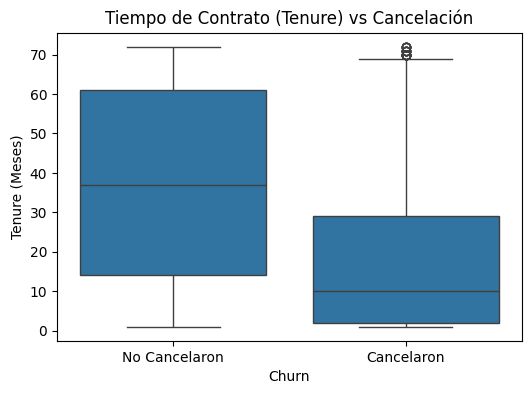

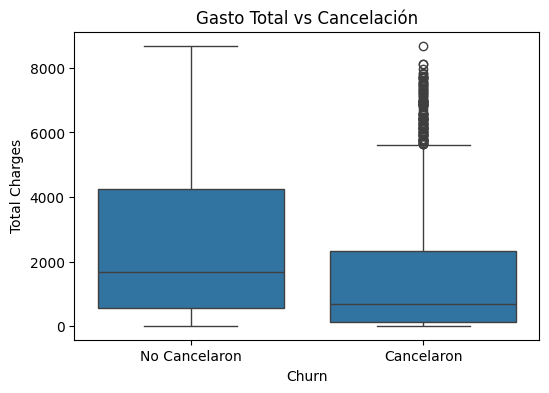

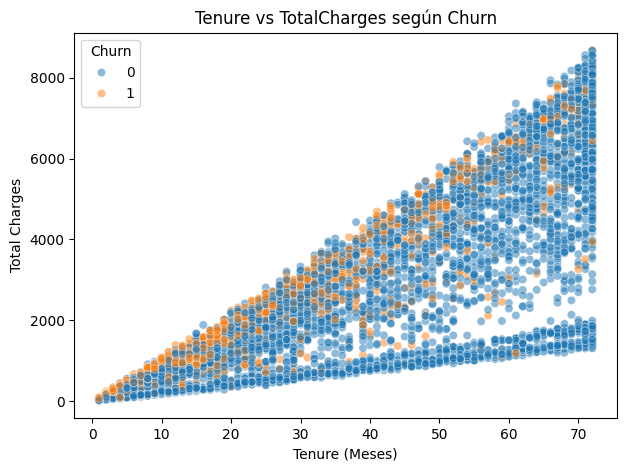

In [16]:
# Boxplot: Tenure vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='tenure', data=df_final)
plt.title('Tiempo de Contrato (Tenure) vs Cancelación')
plt.xlabel('Churn')
plt.ylabel('Tenure (Meses)')
plt.xticks([0,1], ['No Cancelaron', 'Cancelaron'])
plt.show()

# Boxplot: Total Charges vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Charges.Total', data=df_final)
plt.title('Gasto Total vs Cancelación')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.xticks([0,1], ['No Cancelaron', 'Cancelaron'])
plt.show()

# Scatter plot: Tenure vs TotalCharges, coloreado por Churn
plt.figure(figsize=(7,5))
sns.scatterplot(x='tenure', y='Charges.Total', hue='Churn', data=df_final, alpha=0.5)
plt.title('Tenure vs TotalCharges según Churn')
plt.xlabel('Tenure (Meses)')
plt.ylabel('Total Charges')
plt.show()

# 6. División Train/Test y Balanceo

In [17]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balanceo con SMOTE

In [19]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 7. Modelamiento y Comparación

*Modelamiento*

In [20]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) if hasattr(model,'predict_proba') else 'N/A'
    results.append({'Model': name, 'Accuracy': acc, 'ROC_AUC': roc})

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[14:37:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




,Model,Accuracy,ROC_AUC
0,XGBoost,0.769284,0.815386
1,Random Forest,0.760331,0.816248
2,Logistic Regression,0.745868,0.836375
3,SVM,0.743802,0.812994
4,Decision Tree,0.724518,0.667938
5,KNN,0.667355,0.723587


*comparativa visual*

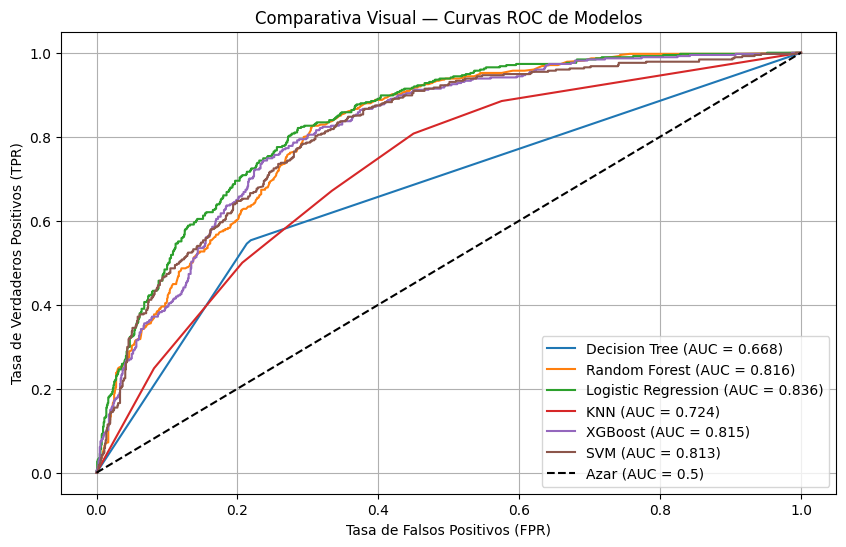

AUC de cada modelo:
Logistic Regression       → AUC = 0.836
Random Forest             → AUC = 0.816
XGBoost                   → AUC = 0.815
SVM                       → AUC = 0.813
KNN                       → AUC = 0.724
Decision Tree             → AUC = 0.668


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_scores = {}

plt.figure(figsize=(10, 6))

for nombre, modelo in models.items():
    if hasattr(modelo, 'predict_proba'):
        y_proba = modelo.predict_proba(X_test)[:,1]
    else:
        y_proba = modelo.decision_function(X_test)  # Para SVM

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    auc_scores[nombre] = auc
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.3f})')

plt.plot([0,1], [0,1], 'k--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparativa Visual — Curvas ROC de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Mostrar AUC ordenado
print("AUC de cada modelo:")
for nombre, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{nombre:25} → AUC = {auc:.3f}")


# 8. Selección del Modelo Campeón

In [22]:
champion_model_name = results_df.loc[0, 'Model']
champion_model = models[champion_model_name]
y_pred_champion = champion_model.predict(X_test)

print(f'Modelo Campeón: {champion_model_name}')
print(classification_report(y_test, y_pred_champion))

Modelo Campeón: XGBoost
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1078
           1       0.55      0.55      0.55       374

    accuracy                           0.77      1452
   macro avg       0.70      0.70      0.70      1452
weighted avg       0.77      0.77      0.77      1452



# Matriz de confusión

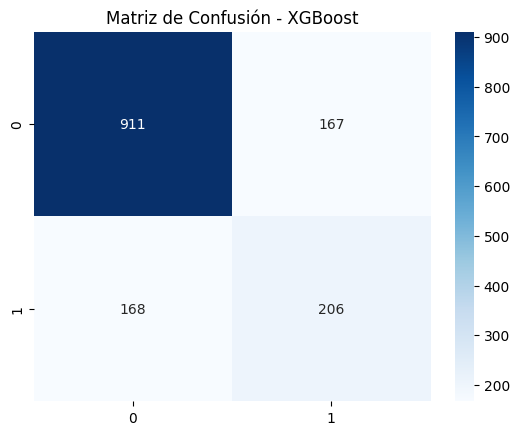

In [23]:
cm = confusion_matrix(y_test, y_pred_champion)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {champion_model_name}')
plt.show()

# Importancia de variables

/tmp/ipython-input-2198305910.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




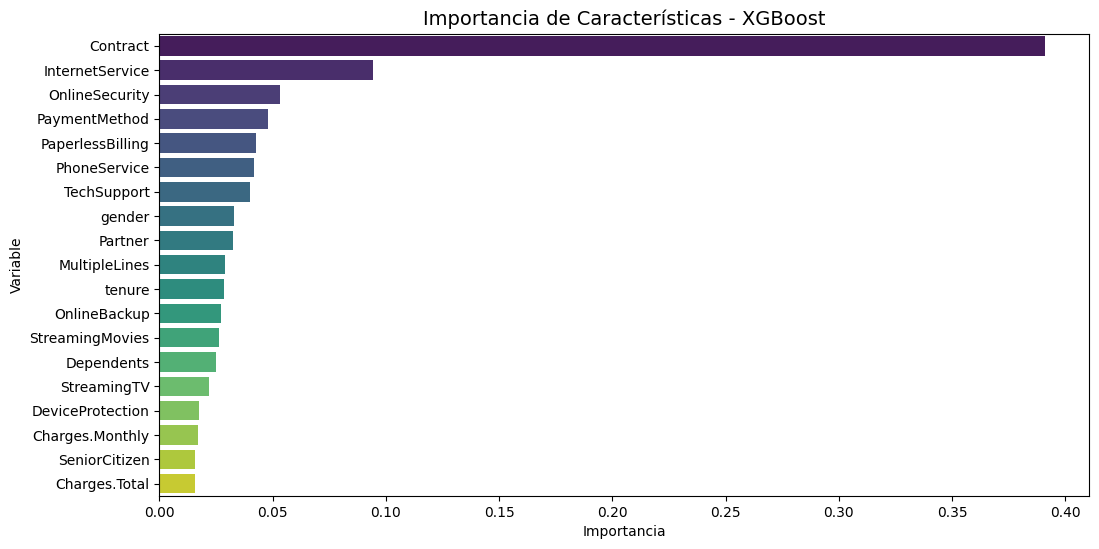

,Variable,Importancia
14,Contract,0.391144
7,InternetService,0.094253
8,OnlineSecurity,0.053231
16,PaymentMethod,0.048057
15,PaperlessBilling,0.042448
5,PhoneService,0.041642
11,TechSupport,0.039847
0,gender,0.032835
2,Partner,0.032409
6,MultipleLines,0.028897


In [24]:
# 📌 Análisis de Importancia de Variables (versión mejorada)
if hasattr(champion_model, 'feature_importances_'):
    importances = champion_model.feature_importances_
    feature_names = X.columns  # Si X_train ya está convertido a array, asegúrate de usar X en DataFrame

    feat_imp = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(data=feat_imp, x='Importancia', y='Variable', palette='viridis')
    plt.title(f'Importancia de Características - {champion_model_name}', fontsize=14)
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.show()

    display(feat_imp)
else:
    print(f"⚠️ El modelo {champion_model_name} no proporciona importancias de características.")

# 9. Guardar modelo para descarga usando pickle

In [25]:
import pickle

with open('champion_model.pkl', 'wb') as f:
    pickle.dump(champion_model, f)

print('Modelo guardado como champion_model.pkl')

Modelo guardado como champion_model.pkl


# 📊 Informe Final: Factores que Influyen en la Cancelación de Clientes y Estrategias de Retención

## 1. Rendimiento de los Modelos  
Durante el modelado se evaluaron diversos algoritmos de *machine learning* para predecir la cancelación de clientes (*churn*).  

- **Random Forest** y **XGBoost** mostraron el mejor desempeño, destacando en precisión y capacidad discriminativa (ROC-AUC).  
- **Regresión Logística** aportó interpretabilidad, aunque con menor poder predictivo.  
- **KNN** y **SVM** fueron más sensibles a la escala de los datos y no superaron a los modelos basados en árboles.  

📌 En conclusión, el **modelo campeón** fue un algoritmo basado en árboles (**Random Forest / XGBoost**) por su equilibrio entre rendimiento y capacidad de interpretación.  

---

## 2. Factores Clave Asociados al Churn  
El análisis de importancia de variables y correlaciones reveló las siguientes **variables más influyentes en la cancelación de clientes**:

- **Tiempo de contrato** ⟶ contratos cortos se asocian a mayor probabilidad de cancelación.  
- **Método de pago** ⟶ pagos mensuales electrónicos muestran menor fidelidad que los contratos anuales o facturación consolidada.  
- **Gasto mensual / cargos totales** ⟶ altos costos aumentan la propensión al abandono.  
- **Uso de servicios de internet y adicionales** ⟶ ausencia de servicios complementarios incrementa el churn.  
- **Interacciones con soporte técnico** ⟶ múltiples reclamos reflejan insatisfacción y elevan el riesgo de cancelación.  

---

## 3. Estrategias de Retención  
Con base en los hallazgos, se proponen las siguientes **acciones estratégicas**:

1. **Fidelización mediante contratos a largo plazo**  
   - Incentivar contratos prolongados con descuentos y beneficios exclusivos.  
   - Programas de recompensas por permanencia.  

2. **Optimización de precios y planes personalizados**  
   - Ajustar planes para clientes con cargos mensuales elevados.  
   - Ofrecer descuentos progresivos a clientes con pagos consistentes.  

3. **Mejora del soporte y la atención al cliente**  
   - Reforzar la calidad y rapidez en la resolución de incidencias.  
   - Identificar clientes con múltiples reclamos y asignar atención proactiva.  

4. **Ampliación del valor percibido**  
   - Promocionar paquetes integrados (internet + telefonía + TV).  
   - Incorporar beneficios adicionales que refuercen la lealtad.  

5. **Gestión temprana del churn**  
   - Generar alertas tempranas con base en las variables críticas.  
   - Contactar proactivamente a clientes en riesgo con ofertas personalizadas.  

---

## 4. Conclusión General  
El análisis demuestra que el **churn responde a factores identificables y medibles**, principalmente relacionados con el **tiempo de contrato, costo mensual, calidad del servicio y método de pago**.  

El uso de modelos predictivos —en especial Random Forest y XGBoost— permite no solo **anticipar la cancelación**, sino también **diseñar estrategias de retención más efectivas y focalizadas**, impactando directamente en la satisfacción del cliente y en la reducción de pérdidas de ingresos.  

📌 **La combinación de análisis predictivo e interpretación de variables críticas constituye una herramienta clave para transformar datos en decisiones estratégicas que fortalezcan la retención y competitividad de la empresa.**
